# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create sbml model from scratch
!./createSteadystateExampleSBML.py > model_steadystate_scaled.sbml

In [3]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

In [4]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']
Parameters:  ['p1', 'p2', 'p3', 'p4', 'p5', 'k0', 'observable_x1', 'observable_x2', 'observable_x3', 'scaling_x1', 'observable_x1_scaled', 'offset_x2', 'observable_x2_offsetted', 'observable_x1withsigma_sigma', 'observable_x1withsigma']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Generate model code

In [5]:
observables = []
fixed_parameters = ['k0']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(sbml, filter=lambda variableId: 
                                                    variableId.startswith('observable_') and not variableId.endswith('_sigma'))
    
    print(observables)
    print(fixed_parameters)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters,
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})


createModule(sbml_file, model_name, model_output_dir)



{'observable_x1': 'x1', 'observable_x2': 'x2', 'observable_x3': 'x3', 'observable_x1_scaled': 'scaling_x1 * x1', 'observable_x2_offsetted': 'offset_x2 + x2', 'observable_x1withsigma': 'x1'}
['k0']


## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'t': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 0.41721488, 0.6707597 ],
       [0.15106393, 0.43460508, 0.64095895],
       [0.20141095, 0.46753068, 0.58381562],
       [0.291

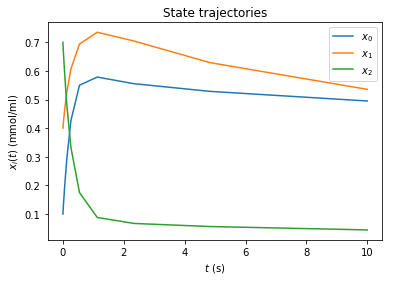

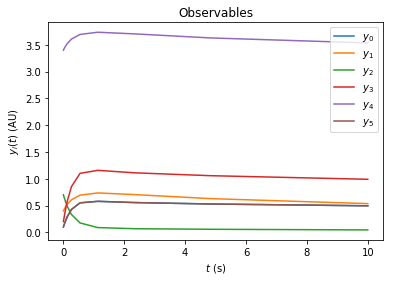

In [7]:
# load model
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [8]:
expectedLlh = 0.0
sigma_default = 0.1 # parameters are lin
sigma_parameter = 0.2
offset_batch_1 = 3.0
offset_batch_2 = 4.0
offsetted_observable_idx = 4
sigma_parameter_observable_idx = 5
model_offset_parameter_idx = 6
sigma_parameter_idx = 7
timepoints = np.logspace(-5, 1, 20)

model = modelModule.getModel()
default_parameters = np.array(model.getParameters())
default_parameters[sigma_parameter_idx] = sigma_parameter
true_parameters = default_parameters.copy()
true_parameters = np.append(true_parameters, offset_batch_2) # add second offset parameter
print('true_parameters: %s' % true_parameters)

def createData():
    # setup model & solver
    model = modelModule.getModel()
    model.setTimepoints(amici.DoubleVector(timepoints))
    model.setParameters(amici.DoubleVector(default_parameters))
    print('Default parameters: ', default_parameters)
    
    solver = model.getSolver()
    solver.setMaxSteps(10000)

    # generate conditon-vectors
    conditions = [np.array(model.getFixedParameters())]
    conditions.append(conditions[0] * 1.1)
    conditions.append(conditions[0] * 1.2)
    conditions.append(conditions[0] * 1.3)

    conditionDf = createConditionDataframe(fixed_parameters, conditions)
    
    df = pd.DataFrame(data={
        'observable': [],
        'condition': [],
        'conditionRef': [],
        'scalingParameter': [],
        'time': [],
        'measurement': [],
        'sigma': []
    })

    global expectedLlh
    for icondition, condition in enumerate(conditions):      
        print('Condition %d: %s' % (icondition, condition))
        
        # different offset for two "batches"
        batch_id = icondition % 2
        if batch_id == 0:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_1
        else:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_2
        
        sigmay = np.ones(shape=(model.nt(), model.nytrue)) * sigma_default
        sigmay[:, sigma_parameter_observable_idx] = np.nan # observable with sigma parameter
        
        # simulate condition
        rdata = getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay)
        
        print('\tllh: ', rdata['llh'])
        print('\tsllh', rdata['sllh'])

        expectedLlh += rdata['llh']
        
        conditionName = 'condition-%d' % icondition
        
        # Append data
        for iy, observableName in enumerate(observables.keys()):
            scalingParameter = [''] 
            sigma = sigmay[:, iy]
            
            if observableName == 'observable_x1_scaled':
                #scalingParameter = ['scaling_x1_%s' % conditionName]
                scalingParameter = ['scaling_x1_common']
            elif observableName == 'observable_x2_offsetted':
                #scalingParameter = ['offset_x2_%s' % conditionName]
                #scalingParameter = ['offset_x2_common']
                scalingParameter = ['offset_x2_batch-%d' % batch_id]
            elif observableName == 'observable_x1withsigma':
                #scalingParameter = ['observable_x1withsigma_sigma_%s' % conditionName]
                scalingParameter = ['observable_x1withsigma_sigma_common']
            
            df = df.append(pd.DataFrame(
            {'observable'      : [observableName] * model.nt(),
             'condition'       : [conditionName]  * model.nt(),
             'conditionRef'    : ['']  * model.nt(),
             'scalingParameter': scalingParameter * model.nt(),
             'time'            : np.array(model.getTimepoints()),
             'measurement'     : rdata['y'][:, iy],
             'sigma'           : sigma
             }), ignore_index=True)
    print('Expected llh: ', expectedLlh)
            
    return df, conditionDf


def createConditionDataframe(fixed_parameters, conditions):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index = fixed_parameters)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf


def getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay):
    model.setParameters(amici.DoubleVector(simulationParameters))
    
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 

    # confirm gradient is 0 for real measurements and save expected llh
    measurement = rdata['y']
    measurement = np.random.normal(loc=rdata['y'], scale=sigmay)
    print(sigmay)
    measurement[:, sigma_parameter_observable_idx] = np.random.normal(
        loc=rdata['y'][:, sigma_parameter_observable_idx], 
        scale=simulationParameters[sigma_parameter_idx])
    print((measurement-rdata['y'])/rdata['y'])

    edata.my = amici.DoubleVector(measurement.flatten())
    edata.sigmay = amici.DoubleVector(sigmay.flatten())
    solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
    solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    # return generated noisy measurents
    rdata['y'] = measurement
    return rdata

df, conditionDf = createData()

true_parameters: [1.  0.5 0.4 2.  0.1 2.  3.  0.2 4. ]
Default parameters:  [1.  0.5 0.4 2.  0.1 2.  3.  0.2]
Condition 0: [1.]
[[0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]
 [0.1 0.1 0.1 0.1 0.1 nan]]
[[ 1.12187207e+00 -3.82699351e-01 -7.31944758e-03  3.89894569e-01
  -5.88050914e-03  3.96768438e-01]
 [-1.37674050e+00  1.41771147e-01  3.75979092e-02  2.20864368e-01
   9.48432135e-05  4.06259466e+00]
 [-9.40274547e-01  2.68823015e-02  1.13122195e-01  1.62819826e-03
   4.28483873e-04  2.19964078e+00]
 [-3.16008517e+00  1.0669599

	llh:  100.02780779268934
	sllh [-14.61232173 -30.26212495  42.21023825   7.49519085 112.88735702
  25.83431668 -65.08680366  -6.27743956]
Expected llh:  359.6875211696888


In [9]:
df

,condition,conditionRef,measurement,observable,scalingParameter,sigma,time
0,condition-0,,0.212225,observable_x1,,0.1,0.000010
1,condition-0,,-0.037688,observable_x1,,0.1,0.000021
2,condition-0,,0.005977,observable_x1,,0.1,0.000043
3,condition-0,,-0.216349,observable_x1,,0.1,0.000089
4,condition-0,,0.066624,observable_x1,,0.1,0.000183
5,condition-0,,0.071179,observable_x1,,0.1,0.000379
6,condition-0,,0.352560,observable_x1,,0.1,0.000785
7,condition-0,,-0.050054,observable_x1,,0.1,0.001624
8,condition-0,,0.025651,observable_x1,,0.1,0.003360
9,condition-0,,0.122927,observable_x1,,0.1,0.006952


In [10]:
conditionDf

,ID,condition-0,condition-1,condition-2,condition-3
k0,k0,1.0,1.1,1.2,1.3


In [11]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

! /bin/bash -c "if [[ -f example_data.h5 ]]; then cp example_data.h5 example_data.h5.bak; fi"
# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
assert out.returncode==0


Measurements shape (480, 7)
Changing t = Inf to t = 1e8.
Num conditions:  4
Num timepoints:  20 [1e-05, 2.0691380811147897e-05, 4.281332398719396e-05, 8.858667904100833e-05, 0.0001832980710832436, 0.000379269019073225, 0.0007847599703514606, 0.001623776739188721, 0.003359818286283781, 0.006951927961775605, 0.014384498882876632, 0.029763514416313162, 0.061584821106602614, 0.1274274985703132, 0.26366508987303555, 0.5455594781168515, 1.1288378916846884, 2.3357214690901213, 4.832930238571752, 10.0]
Fixed parameters orginal:  (1, 4)
Fixed parameters usable:  (1, 4)
Generate parameter list...
Number of simulation parameters: 8
Number of optimization parameters: 9
Generating fixed parameters matrix...
Number of fixed parameters: 1
Generating measurement matrix...
Number of observables: 6
Handling scaling parameters...
Ensure that scaling_x1_common is selected correctly as proportionality factor for hierarchical optimization ().
Number of proportionality factors for hierarchical optimization: 

In [12]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
import h5py
with h5py.File(hdf5File, 'r+') as f:
    pscale = f['/parameters/pscale'][:]
    true_parameters_scaled = true_parameters.copy()
    for i, p in enumerate(pscale):
        if p == 2:
            true_parameters_scaled[i] = np.log10(true_parameters[i])
    
    for i in range(10):
        parameters = true_parameters_scaled
        #parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        #parameters = np.random.uniform(-3, 5, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters


In [13]:
# enable derivate checker
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes
!../../../misc/optimizationOptions.py example_data.h5 -s numStarts 2
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            2
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Gradient check

In [14]:
for i in range(3):
    !PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


[2018-08-12 13:09:45] [ERR] [-1/]     0 g: -9.00959e+08  fd_c:            0  Δ/fd_c: -9.009593e+13  f:  1.59275e+22
[2018-08-12 13:09:45] [ERR] [-1/]     1 g:   8.8347e+10  fd_c:            0  Δ/fd_c: 8.834702e+15  f:  1.59275e+22
[2018-08-12 13:09:45] [ERR] [-1/]     2 g:  5.50086e+11  fd_c:            0  Δ/fd_c: 5.500858e+16  f:  1.59275e+22
[2018-08-12 13:09:45] [ERR] [-1/]     3 g: -3.24183e+11  fd_c:            0  Δ/fd_c: -3.241827e+16  f:  1.59275e+22
[2018-08-12 13:09:45] [ERR] [-1/]     4 g:     -11542.2  fd_c:            0  Δ/fd_c: -1.154223e+09  f:  1.59275e+22
[2018-08-12 13:09:45] [ERR] [-1/]     5 g:     -8.04559  fd_c:            0  Δ/fd_c: -8.045591e+05  f:  1.59275e+22
[2018-08-12 13:09:45] [ERR] [-1/]     6 g: -1.00776e+13  fd_c:            0  Δ/fd_c: -1.007762e+18  f:  1.59275e+22
[2018-08-12 13:09:45] [ERR] [-1/]     7 g: -1.48473e+07  fd_c:            0  Δ/fd_c: -1.484730e+12  f:  1.59275e+22
[2018-08-12 13:09:45] [ERR] [-1/]     8 g:  5.08539e+12  fd_c:            

## Optimize

In [15]:
!pwd
!(cd ../../../build && exec make -j12)
!../../../build/amici/examples/steadystate/example_steadystate_multi -o deleteme/ example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
-- Found Git: /usr/bin/git (found version "2.17.1") 
Scanning dependencies of target model_steadystate_scaled
[  7%] Built target parpecommon
-- Building version parPE-v0.1.7-93-gbcbd8-dirty
[  7%] Built target get_version
[  7%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JSparseB.cpp.o
[  8%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_J.cpp.o
[  9%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JDiag.cpp.o
[ 11%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_Jv.cpp.o
[ 11%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystat

[2018-08-12 13:10:29] [DBG] [-1/] Result for 0.0.0.0 (0): 98.2318 (0) (0.0211s)
[2018-08-12 13:10:29] [DBG] [-1/] Result for 0.0.0.1 (1): 86.1575 (0) (0.0139s)
[2018-08-12 13:10:29] [DBG] [-1/] Result for 0.0.0.2 (2): 75.2704 (0) (0.0156s)
[2018-08-12 13:10:29] [DBG] [-1/] Result for 0.0.0.3 (3): 100.028 (0) (0.0094s)
Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2018-08-12 13:10:29] [INF] [-1/] iter: 0 cost: -359.688 time_iter: 0.0996093s time_optim: 0.0996095s
i

[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.3 (3): -338.382 (0) (0.0088s)
[2018-08-12 13:10:30] [INF] [-1/] iter: 5 cost: 1181.48 time_iter: 0.0586235s time_optim: 0.442122s
   5  1.1814811e+03 0.00e+00 1.60e+02   5.2 1.75e-01    -  1.00e+00 1.00e+00f  1
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.0 (0): -313.014 (0) (0.0008s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.1 (1): -236.27 (0) (0.0009s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.2 (2): -278.934 (0) (0.0008s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.3 (3): -326.322 (0) (0.0008s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.0 (0): -313.014 (0) (0.0081s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.1 (1): -236.27 (0) (0.0085s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.2 (2): -278.934 (0) (0.0087s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.3 (3): -326.322 (0) (0.0087s)
[2018-08-12 13:10:30] [INF] [-1/] iter: 6 cost: 1154.54 time_iter: 0.0593509s time_optim: 0.

[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.2 (2): 57.6956 (0) (0.0092s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.3 (3): 63.3014 (0) (0.0093s)
[2018-08-12 13:10:30] [INF] [-1/] iter: 12 cost: -245.375 time_iter: 0.0620908s time_optim: 0.902004s
  12 -2.4537479e+02 0.00e+00 3.02e+02   1.7 1.50e-01    -  1.00e+00 1.00e+00f  1
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.0 (0): 85.3067 (0) (0.0009s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.1 (1): 57.0145 (0) (0.0009s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.2 (2): 63.7686 (0) (0.0009s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.3 (3): 90.745 (0) (0.0009s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.0 (0): 85.3067 (0) (0.0098s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.1 (1): 57.0145 (0) (0.0092s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.2 (2): 63.7686 (0) (0.0093s)
[2018-08-12 13:10:30] [DBG] [-1/] Result for 0.0.0.3 (3): 90.745 (0) (0.0102s)
[2018-08-12 13:10:3

[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.2 (2): 76.65 (0) (0.0103s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.3 (3): 100.227 (0) (0.0100s)
[2018-08-12 13:10:31] [INF] [-1/] iter: 20 cost: -359.701 time_iter: 0.0788419s time_optim: 1.46864s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.5970098e+02 0.00e+00 4.51e+01   0.3 1.33e-02    -  1.00e+00 5.00e-01f  2
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.0 (0): 96.5103 (0) (0.0008s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.1 (1): 87.1095 (0) (0.0008s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.2 (2): 76.468 (0) (0.0008s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.3 (3): 99.7229 (0) (0.0008s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.0 (0): 96.5103 (0) (0.0104s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.1 (1): 87.1095 (0) (0.0099s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.2 (2): 76.468 (0) (0.0114s)
[2018-08-12 13:10:31]

[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.0 (0): 97.6065 (0) (0.0105s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.1 (1): 85.233 (0) (0.0105s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.2 (2): 78.1762 (0) (0.0108s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.3 (3): 100.543 (0) (0.0105s)
[2018-08-12 13:10:31] [INF] [-1/] iter: 26 cost: -361.559 time_iter: 0.0898196s time_optim: 1.95572s
  26 -3.6155874e+02 0.00e+00 1.07e+02  -8.3 1.43e-01    -  1.00e+00 1.25e-01f  4
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.0 (0): 98.5451 (0) (0.0009s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.1 (1): 85.79 (0) (0.0008s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.2 (2): 76.7839 (0) (0.0008s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.3 (3): 100.389 (0) (0.0009s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.0 (0): 98.5451 (0) (0.0011s)
[2018-08-12 13:10:31] [DBG] [-1/] Result for 0.0.0.1 (1): 85.79 (0) (0.0009s)
[2018-08-12 13:10:31] [

[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.1 (1): 86.5009 (0) (0.0119s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.2 (2): 77.595 (0) (0.0116s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.3 (3): 100.783 (0) (0.0105s)
[2018-08-12 13:10:32] [INF] [-1/] iter: 32 cost: -363.044 time_iter: 0.099545s time_optim: 2.45904s
  32 -3.6304416e+02 0.00e+00 1.59e+01 -11.0 3.32e-01    -  1.00e+00 6.25e-02f  5
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.0 (0): 97.8146 (0) (0.0012s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.1 (1): 86.5143 (0) (0.0010s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.2 (2): 77.4872 (0) (0.0011s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.3 (3): 101.475 (0) (0.0009s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.0 (0): 97.8146 (0) (0.0111s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.1 (1): 86.5143 (0) (0.0102s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.2 (2): 77.4872 (0) (0.0103s)
[2018-08-12 13:10:32

[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.3 (3): 101.663 (0) (0.0009s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.0 (0): 97.595 (0) (0.0144s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.1 (1): 87.7618 (0) (0.0108s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.2 (2): 76.4767 (0) (0.0108s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.3 (3): 101.663 (0) (0.0111s)
[2018-08-12 13:10:32] [INF] [-1/] iter: 36 cost: -363.497 time_iter: 0.0911121s time_optim: 2.84076s
  36 -3.6349682e+02 0.00e+00 7.70e+01 -11.0 1.86e-01    -  1.00e+00 2.50e-01f  3
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.0 (0): 97.641 (0) (0.0008s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.1 (1): 88.0344 (0) (0.0008s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.2 (2): 76.3689 (0) (0.0009s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.3 (3): 100.398 (0) (0.0013s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.0 (0): 97.641 (0) (0.0008s)
[2018-08-12 13:10:32]

[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.2 (2): 76.767 (0) (0.0126s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.3 (3): 101.826 (0) (0.0142s)
[2018-08-12 13:10:32] [INF] [-1/] iter: 40 cost: -363.965 time_iter: 0.114998s time_optim: 3.21536s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -3.6396470e+02 0.00e+00 1.26e+01 -11.0 3.57e-01    -  1.00e+00 1.56e-02f  7
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.0 (0): 98.3166 (0) (0.0009s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5377 (0) (0.0008s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.2 (2): 76.3122 (0) (0.0008s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.3 (3): 101.721 (0) (0.0008s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.0 (0): 98.3166 (0) (0.0008s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5377 (0) (0.0008s)
[2018-08-12 13:10:32] [DBG] [-1/] Result for 0.0.0.2 (2): 76.3122 (0) (0.0008s)
[2018-08-12 13:10:3

[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.1 (1): 87.6566 (0) (0.0112s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8417 (0) (0.0112s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.3 (3): 101.569 (0) (0.0122s)
[2018-08-12 13:10:33] [INF] [-1/] iter: 44 cost: -364.031 time_iter: 0.0993104s time_optim: 3.58463s
  44 -3.6403062e+02 0.00e+00 3.41e+00 -11.0 3.45e-02    -  1.00e+00 1.25e-01f  4
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.0 (0): 97.9685 (0) (0.0009s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.1 (1): 87.6621 (0) (0.0009s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8657 (0) (0.0008s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.3 (3): 101.5 (0) (0.0011s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.0 (0): 97.9685 (0) (0.0012s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.1 (1): 87.6621 (0) (0.0012s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8657 (0) (0.0012s)
[2018-08-12 13:10:33

[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0788 (0) (0.0009s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5385 (0) (0.0009s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.2 (2): 76.7707 (0) (0.0009s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.3 (3): 101.646 (0) (0.0011s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0788 (0) (0.0113s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5385 (0) (0.0110s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.2 (2): 76.7707 (0) (0.0119s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.3 (3): 101.646 (0) (0.0114s)
[2018-08-12 13:10:33] [INF] [-1/] iter: 48 cost: -364.034 time_iter: 0.0988793s time_optim: 3.96976s
  48 -3.6403442e+02 0.00e+00 9.78e-01 -11.0 6.91e-03    -  1.00e+00 1.25e-01f  4
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.0 (0): 98.04 (0) (0.0008s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5898 (0) (0.0008s)
[2018-08-12 13:10:33

[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.2 (2): 76.7997 (0) (0.0107s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.3 (3): 101.619 (0) (0.0133s)
[2018-08-12 13:10:33] [INF] [-1/] iter: 52 cost: -364.035 time_iter: 0.0720902s time_optim: 4.32969s
  52 -3.6403532e+02 0.00e+00 5.29e-01 -11.0 1.91e-03    -  1.00e+00 1.00e+00f  1
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.0 (0): 98.1951 (0) (0.0008s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.1 (1): 87.3511 (0) (0.0008s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.2 (2): 76.704 (0) (0.0008s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.3 (3): 101.693 (0) (0.0008s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.0 (0): 98.1951 (0) (0.0008s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.1 (1): 87.3511 (0) (0.0008s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.2 (2): 76.704 (0) (0.0010s)
[2018-08-12 13:10:33] [DBG] [-1/] Result for 0.0.0.3 (3): 101.693 (0) (0.0009s)
[2018-08-12 13:10:33

[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0401 (0) (0.0118s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5722 (0) (0.0129s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8077 (0) (0.0111s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.3 (3): 101.615 (0) (0.0113s)
[2018-08-12 13:10:34] [INF] [-1/] iter: 57 cost: -364.035 time_iter: 0.0989461s time_optim: 4.77578s
  57 -3.6403547e+02 0.00e+00 2.35e-01 -11.0 4.06e-03    -  1.00e+00 6.25e-02f  5
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.0 (0): 98.035 (0) (0.0010s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.1 (1): 87.6468 (0) (0.0012s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.2 (2): 76.798 (0) (0.0011s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.3 (3): 101.554 (0) (0.0011s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.0 (0): 98.035 (0) (0.0009s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.1 (1): 87.6468 (0) (0.0008s)
[2018-08-12 13:10:34]

[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.3 (3): 101.601 (0) (0.0010s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0479 (0) (0.0009s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5584 (0) (0.0009s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8224 (0) (0.0010s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.3 (3): 101.607 (0) (0.0009s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0488 (0) (0.0008s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5608 (0) (0.0008s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8161 (0) (0.0009s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.3 (3): 101.61 (0) (0.0008s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0488 (0) (0.0108s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5608 (0) (0.0104s)
[2018-08-12 13:10:34] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8161 (0) (0.0115s)
[2018-08-12 13:10:34] [DBG] [-1/] Result 

[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8122 (0) (0.0106s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.3 (3): 101.614 (0) (0.0106s)
[2018-08-12 13:10:35] [INF] [-1/] iter: 65 cost: -364.036 time_iter: 0.0984194s time_optim: 5.51004s
  65 -3.6403555e+02 0.00e+00 5.74e-02 -11.0 4.65e-04    -  1.00e+00 6.25e-02f  5
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.0 (0): 98.045 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5685 (0) (0.0008s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8125 (0) (0.0008s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.3 (3): 101.61 (0) (0.0008s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0447 (0) (0.0011s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.1 (1): 87.567 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8124 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.3 (3): 101.612 (0) (0.0009s)
[2018-08-12 13:10:35]

[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0445 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.1 (1): 87.566 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8114 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.3 (3): 101.614 (0) (0.0011s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0445 (0) (0.0011s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5654 (0) (0.0012s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8123 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.3 (3): 101.613 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0446 (0) (0.0010s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5651 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8127 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.3 (3): 101.613 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result 

[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8131 (0) (0.0013s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.3 (3): 101.612 (0) (0.0012s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0444 (0) (0.0012s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5655 (0) (0.0012s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.2 (2): 76.813 (0) (0.0011s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.3 (3): 101.613 (0) (0.0009s)
[2018-08-12 13:10:35] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0445 (0) (0.0008s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5653 (0) (0.0008s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.2 (2): 76.813 (0) (0.0010s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.3 (3): 101.613 (0) (0.0012s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0445 (0) (0.0012s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5652 (0) (0.0012s)
[2018-08-12 13:10:36] [DBG] [-1/] Result f

[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.0 (0): 60.1578 (0) (0.0102s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.1 (1): 70.1873 (0) (0.0104s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.2 (2): 46.9473 (0) (0.0098s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.3 (3): 55.8277 (0) (0.0098s)
[2018-08-12 13:10:36] [INF] [-1/] iter: 1 cost: -233.12 time_iter: 0.112319s time_optim: 0.182925s
   1 -2.3312016e+02 0.00e+00 1.07e+03   3.3 2.61e+02    -  9.90e-01 6.27e-04f  6
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.0 (0): -40638.2 (0) (0.0009s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.1 (1): -33732.2 (0) (0.0009s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.2 (2): -35406.2 (0) (0.0009s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.3 (3): -41577.3 (0) (0.0009s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.0 (0): -40638.2 (0) (0.0008s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.1 (1): -33732.2 (0) (0.0009s)
[2018-08-12 13

[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.0 (0): -36.7952 (0) (0.0101s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.1 (1): -113.441 (0) (0.0110s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.2 (2): -30.3043 (0) (0.0087s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.3 (3): -144.249 (0) (0.0093s)
[2018-08-12 13:10:36] [INF] [-1/] iter: 9 cost: 324.789 time_iter: 0.0901427s time_optim: 0.744435s
   9  3.2478902e+02 0.00e+00 1.89e+03   2.4 1.86e+00    -  8.72e-01 1.25e-01f  4
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.0 (0): -67.394 (0) (0.0011s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.1 (1): -180.695 (0) (0.0012s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.2 (2): -97.5413 (0) (0.0012s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.3 (3): -159.147 (0) (0.0012s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.0 (0): -67.394 (0) (0.0012s)
[2018-08-12 13:10:36] [DBG] [-1/] Result for 0.0.0.1 (1): -180.695 (0) (0.0009s)
[2018-08-12

[2018-08-12 13:10:37] [DBG] [-1/] Result for 0.0.0.2 (2): 76.289 (0) (0.0009s)
[2018-08-12 13:10:37] [DBG] [-1/] Result for 0.0.0.3 (3): 99.0699 (0) (0.0010s)
[2018-08-12 13:10:37] [DBG] [-1/] Result for 0.0.0.0 (0): 95.3734 (0) (0.0113s)
[2018-08-12 13:10:37] [DBG] [-1/] Result for 0.0.0.1 (1): 87.1886 (0) (0.0105s)
[2018-08-12 13:10:37] [DBG] [-1/] Result for 0.0.0.2 (2): 76.289 (0) (0.0102s)
[2018-08-12 13:10:37] [DBG] [-1/] Result for 0.0.0.3 (3): 99.0699 (0) (0.0110s)
[2018-08-12 13:10:37] [INF] [-1/] iter: 17 cost: -357.921 time_iter: 0.0897037s time_optim: 1.3657s
  17 -3.5792094e+02 0.00e+00 1.23e+02   0.3 1.30e-01    -  1.00e+00 2.50e-01f  3
[2018-08-12 13:10:37] [DBG] [-1/] Result for 0.0.0.0 (0): 96.7155 (0) (0.0012s)
[2018-08-12 13:10:37] [DBG] [-1/] Result for 0.0.0.1 (1): 86.1833 (0) (0.0011s)
[2018-08-12 13:10:37] [DBG] [-1/] Result for 0.0.0.2 (2): 76.743 (0) (0.0012s)
[2018-08-12 13:10:37] [DBG] [-1/] Result for 0.0.0.3 (3): 98.7381 (0) (0.0010s)
[2018-08-12 13:10:37] 

[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.2 (2): 77.6331 (0) (0.0120s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.3 (3): 100.797 (0) (0.0109s)
[2018-08-12 13:10:38] [INF] [-1/] iter: 24 cost: -361.293 time_iter: 0.0918132s time_optim: 1.89471s
  24 -3.6129281e+02 0.00e+00 4.31e+01  -6.1 3.89e-01    -  1.00e+00 2.50e-01f  3
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.0 (0): -6890.3 (0) (0.0015s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.1 (1): -6282.15 (0) (0.0012s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.2 (2): -5339.64 (0) (0.0012s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.3 (3): -4902.21 (0) (0.0012s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.0 (0): -6890.3 (0) (0.0013s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.1 (1): -6282.15 (0) (0.0013s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.2 (2): -5339.64 (0) (0.0013s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.3 (3): -4902.21 (0) (0.0012s)
[2018-08-12 

[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.0 (0): 97.7109 (0) (0.0136s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.1 (1): 86.9568 (0) (0.0118s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.2 (2): 77.8778 (0) (0.0125s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.3 (3): 99.8952 (0) (0.0134s)
[2018-08-12 13:10:38] [INF] [-1/] iter: 28 cost: -362.441 time_iter: 0.0922847s time_optim: 2.29229s
  28 -3.6244073e+02 0.00e+00 3.54e+01 -10.7 4.69e-02    -  1.00e+00 5.00e-01f  2
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.0 (0): 95.902 (0) (0.0009s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.1 (1): 84.3223 (0) (0.0009s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.2 (2): 75.684 (0) (0.0009s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.3 (3): 101.469 (0) (0.0009s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.0 (0): 95.902 (0) (0.0008s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.1 (1): 84.3223 (0) (0.0009s)
[2018-08-12 13:10:38]

[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.1 (1): 86.2451 (0) (0.0010s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.2 (2): 72.4082 (0) (0.0010s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.3 (3): 101.9 (0) (0.0009s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0153 (0) (0.0008s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.1 (1): 86.6764 (0) (0.0008s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.2 (2): 75.8936 (0) (0.0008s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.3 (3): 101.793 (0) (0.0009s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.0 (0): 98.1428 (0) (0.0008s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.1 (1): 86.6622 (0) (0.0008s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.2 (2): 76.9104 (0) (0.0008s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.3 (3): 101.651 (0) (0.0008s)
[2018-08-12 13:10:38] [DBG] [-1/] Result for 0.0.0.0 (0): 98.1428 (0) (0.0114s)
[2018-08-12 13:10:38] [DBG] [-1/] Result f

[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.1 (1): 87.9068 (0) (0.0109s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.2 (2): 77.1559 (0) (0.0103s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.3 (3): 101.085 (0) (0.0102s)
[2018-08-12 13:10:39] [INF] [-1/] iter: 38 cost: -363.703 time_iter: 0.0961293s time_optim: 3.18285s
  38 -3.6370299e+02 0.00e+00 3.56e+01 -11.0 5.06e-01    -  1.00e+00 6.25e-02f  5
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0368 (0) (0.0009s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.1 (1): 87.3266 (0) (0.0008s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.2 (2): 76.6683 (0) (0.0008s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.3 (3): 101.885 (0) (0.0008s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0368 (0) (0.0116s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.1 (1): 87.3266 (0) (0.0103s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.2 (2): 76.6683 (0) (0.0106s)
[2018-08-12 13:10:

[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.1 (1): 87.6265 (0) (0.0009s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8359 (0) (0.0011s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.3 (3): 101.566 (0) (0.0009s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0019 (0) (0.0108s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.1 (1): 87.6265 (0) (0.0107s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8359 (0) (0.0103s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.3 (3): 101.566 (0) (0.0111s)
[2018-08-12 13:10:39] [INF] [-1/] iter: 43 cost: -364.03 time_iter: 0.106259s time_optim: 3.61729s
  43 -3.6403030e+02 0.00e+00 2.52e+00 -11.0 1.67e-01    -  1.00e+00 1.56e-02f  7
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.0 (0): 97.6302 (0) (0.0012s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.1 (1): 87.7991 (0) (0.0011s)
[2018-08-12 13:10:39] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8166 (0) (0.0011s)
[2018-08-12 13:10:39

[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.1 (1): 87.4335 (0) (0.0008s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.2 (2): 76.7513 (0) (0.0010s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.3 (3): 101.731 (0) (0.0010s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0744 (0) (0.0009s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5178 (0) (0.0009s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.2 (2): 76.7608 (0) (0.0010s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.3 (3): 101.68 (0) (0.0009s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0564 (0) (0.0009s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.1 (1): 87.559 (0) (0.0009s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.2 (2): 76.7653 (0) (0.0009s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.3 (3): 101.653 (0) (0.0009s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0564 (0) (0.0107s)
[2018-08-12 13:10:40] [DBG] [-1/] Result f

[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0373 (0) (0.0114s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5816 (0) (0.0121s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8068 (0) (0.0122s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.3 (3): 101.61 (0) (0.0130s)
[2018-08-12 13:10:40] [INF] [-1/] iter: 51 cost: -364.035 time_iter: 0.110433s time_optim: 4.37589s
  51 -3.6403527e+02 0.00e+00 2.73e-01 -11.0 3.01e-03    -  1.00e+00 6.25e-02f  5
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0441 (0) (0.0010s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5728 (0) (0.0012s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.2 (2): 76.7997 (0) (0.0014s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.3 (3): 101.619 (0) (0.0014s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0441 (0) (0.0133s)
[2018-08-12 13:10:40] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5728 (0) (0.0118s)
[2018-08-12 13:10:40

[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0415 (0) (0.0137s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5734 (0) (0.0143s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8073 (0) (0.0156s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.3 (3): 101.613 (0) (0.0155s)
[2018-08-12 13:10:41] [INF] [-1/] iter: 56 cost: -364.035 time_iter: 0.0964877s time_optim: 4.90201s
  56 -3.6403545e+02 0.00e+00 1.29e-01 -11.0 4.34e-04    -  1.00e+00 1.00e+00f  1
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.0 (0): 98.017 (0) (0.0012s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5533 (0) (0.0012s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8114 (0) (0.0011s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.3 (3): 101.648 (0) (0.0011s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.0 (0): 98.017 (0) (0.0012s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5533 (0) (0.0012s)
[2018-08-12 13:10:41

[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0497 (0) (0.0161s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5631 (0) (0.0146s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8098 (0) (0.0154s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.3 (3): 101.613 (0) (0.0146s)
[2018-08-12 13:10:41] [INF] [-1/] iter: 60 cost: -364.035 time_iter: 0.12037s time_optim: 5.43019s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -3.6403550e+02 0.00e+00 3.81e-01 -11.0 5.05e-03    -  1.00e+00 2.50e-01f  3
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0327 (0) (0.0014s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5239 (0) (0.0011s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.2 (2): 76.9084 (0) (0.0012s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.3 (3): 101.564 (0) (0.0012s)
[2018-08-12 13:10:41] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0327 (0) (0.0012s)
[2018-08-12 13:10:4

[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0443 (0) (0.0154s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5662 (0) (0.0152s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8122 (0) (0.0157s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.3 (3): 101.613 (0) (0.0157s)
[2018-08-12 13:10:42] [INF] [-1/] iter: 64 cost: -364.036 time_iter: 0.13976s time_optim: 5.93812s
  64 -3.6403555e+02 0.00e+00 2.89e-02 -11.0 1.91e-03    -  1.00e+00 6.25e-02f  5
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0456 (0) (0.0015s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5528 (0) (0.0012s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8123 (0) (0.0012s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.3 (3): 101.625 (0) (0.0015s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0456 (0) (0.0012s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5528 (0) (0.0012s)
[2018-08-12 13:10:42

[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5649 (0) (0.0149s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8134 (0) (0.0189s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.3 (3): 101.613 (0) (0.0151s)
[2018-08-12 13:10:42] [INF] [-1/] iter: 69 cost: -364.036 time_iter: 0.107928s time_optim: 6.54357s
  69 -3.6403555e+02 0.00e+00 1.01e-02 -11.0 5.69e-05    -  1.00e+00 5.00e-01f  2
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0447 (0) (0.0015s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5645 (0) (0.0016s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8123 (0) (0.0016s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.3 (3): 101.614 (0) (0.0016s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0446 (0) (0.0012s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5647 (0) (0.0011s)
[2018-08-12 13:10:42] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8129 (0) (0.0013s)
[2018-08-12 13:10:4

[2018-08-12 13:10:43] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0445 (0) (0.0155s)
[2018-08-12 13:10:43] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5652 (0) (0.0162s)
[2018-08-12 13:10:43] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8127 (0) (0.0154s)
[2018-08-12 13:10:43] [DBG] [-1/] Result for 0.0.0.3 (3): 101.613 (0) (0.0147s)
[2018-08-12 13:10:43] [INF] [-1/] iter: 73 cost: -364.036 time_iter: 0.13521s time_optim: 7.07449s
  73 -3.6403555e+02 0.00e+00 9.19e-03 -11.0 1.69e-05    -  1.00e+00 6.25e-02f  5
[2018-08-12 13:10:43] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0446 (0) (0.0012s)
[2018-08-12 13:10:43] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5651 (0) (0.0011s)
[2018-08-12 13:10:43] [DBG] [-1/] Result for 0.0.0.2 (2): 76.8129 (0) (0.0013s)
[2018-08-12 13:10:43] [DBG] [-1/] Result for 0.0.0.3 (3): 101.613 (0) (0.0012s)
[2018-08-12 13:10:43] [DBG] [-1/] Result for 0.0.0.0 (0): 98.0446 (0) (0.0162s)
[2018-08-12 13:10:43] [DBG] [-1/] Result for 0.0.0.1 (1): 87.5651 (0) (0.0143s)
[2018-08-12 13:10:43

array([[-359.68752129, -233.1201581 , 1002.597726  , 1542.30380994,
        1197.23737397, 1181.48106317, 1154.54049265, 1025.57464853,
         397.81299986,  324.78902159,   82.1731057 , -135.18292317,
        -245.37478536, -296.83471534, -313.76846267, -352.49777874,
        -357.44779176, -357.92093558, -358.37992927, -359.60796001,
        -359.70098393, -359.81066222, -360.08035656, -360.52093787,
        -361.29280804, -361.38760461, -361.55873963, -362.18001493,
        -362.44073334, -362.60953253, -362.79518713, -363.00614016,
        -363.04416123, -363.29131724, -363.36676305, -363.3796828 ,
        -363.49682362, -363.67177552, -363.70299114, -363.91642155,
        -363.96469976, -364.00293529, -364.02959785, -364.03030353,
        -364.03062024, -364.03210012, -364.03305479, -364.03384896,
        -364.03442465, -364.03520115, -364.03524543, -364.03527407,
        -364.03531722, -364.03534627, -364.0354048 , -364.03541317,
        -364.03545129, -364.03546914, -364.03547

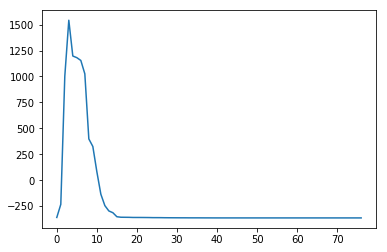

In [16]:
filename = 'deleteme/_rank-0001.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
trajectory

## Compare results

In [17]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [18]:
compareResults('deleteme/_rank-0001.h5', -expectedLlh)

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 1.064554 0.064554 0.064554
1: 0.500000 0.729759 0.229759 0.459518
2: 0.400000 0.451279 0.051279 0.128199
3: 2.000000 2.000258 0.000258 0.000129
4: 0.100000 0.199862 0.099862 0.998617
5: 2.000000 1.912744 -0.087256 -0.043628
6: 3.000000 3.005152 0.005152 0.001717
7: 0.200000 0.197264 -0.002736 -0.013679
8: 4.000000 3.998233 -0.001767 -0.000442
Status: 4
Cost: -364.035549 (expected: -359.687521)


In [19]:
!pwd

/home/dweindl/src/parPE/amici/examples/steadystate


In [20]:
!rm sim.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

Running for start 0
Running for start 1


In [21]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


[ 0.21222497 -0.03768793  0.0059771  -0.21634909  0.06662415  0.07117902
  0.35256016 -0.05005438  0.02565056  0.1229272   0.19076048  0.12937107
  0.13573045  0.47313094  0.34031846  0.48084385  0.50975427  0.4453424
  0.67626608  0.55017465] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.1007243
 0.10149796 0.1030964  0.10639368 0.11317276 0.12701269 0.15484246
 0.20893527 0.30597656 0.44859878 0.57566147 0.60371226 0.58489782
 0.56395019 0.54296921]
[ 0.01078388 -0.04013924  0.07650345  0.04320529  0.05184431  0.01899812
  0.08131954  0.10710955  0.03679566 -0.04132656  0.14765435  0.13885827
  0.21222352  0.25818363  0.51688934  0.52088993  0.80831505  0.63562407
  0.65827427  0.57285387] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.10072429
 0.10149791 0.10309622 0.1063929  0.11316942 0.12699862 0.1547841
 0.20870209 0.30512038 0.44600927 0.57036271 0.59700004 0.57732872
 0.55494511 0.53322715]
[ 0.04882468  0.19965676 -0.0190921   0.15880277  0.0665912   0

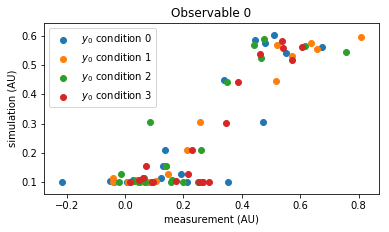

[0.24692785 0.45673752 0.41080699 0.44279896 0.54269522 0.5472063
 0.45422085 0.50442097 0.3679899  0.36420263 0.39503536 0.37443086
 0.44222864 0.50008826 0.53091069 0.54893563 0.69643748 0.81386897
 0.53418117 0.56816564] [0.40001201 0.40002485 0.40005142 0.40010638 0.40022008 0.40045519
 0.40094108 0.40194388 0.40400791 0.40823234 0.41677856 0.43365935
 0.46541273 0.51957158 0.59613448 0.67244237 0.70385163 0.67332559
 0.6118992  0.55105793]
[0.46943513 0.59024881 0.30380227 0.37300195 0.32747276 0.38175043
 0.41795182 0.50270297 0.37967032 0.52535214 0.34584468 0.28369024
 0.58125965 0.41117981 0.62973431 0.70019681 0.66071359 0.57583087
 0.43617843 0.54255725] [0.40001201 0.40002485 0.40005142 0.40010638 0.40022008 0.40045518
 0.40094104 0.4019437  0.40400712 0.408229   0.41676453 0.43360126
 0.46518047 0.51870412 0.59328126 0.66494041 0.68984586 0.65401746
 0.58852157 0.52627263]
[0.39792144 0.45838312 0.53344083 0.50597192 0.40993534 0.42287748
 0.43758464 0.33336713 0.40844684 

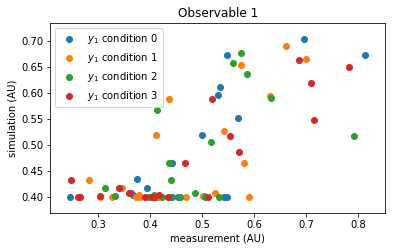

[ 0.69485574  0.72627388  0.77908642  0.63809311  0.68303241  0.75966319
  0.70661843  0.80309469  0.69183801  0.62222988  0.78175945  0.60073625
  0.47474187  0.43191077  0.26346558  0.15106956  0.2778331   0.0765422
  0.27569146 -0.09704166] [0.69997929 0.69995715 0.69991134 0.69981657 0.69962051 0.69921503
 0.69837688 0.6966462  0.69308044 0.68576731 0.6709101  0.6413158
 0.58474465 0.48556579 0.34057653 0.1941878  0.11833602 0.09829815
 0.08521122 0.07320934]
[ 0.94745576  0.59793025  0.54670806  0.77436429  0.67603564  0.54399339
  0.74790909  0.8216325   0.74576214  0.84144661  0.82683416  0.81624084
  0.76619003  0.40103618  0.23596159 -0.01055022  0.32458153  0.03032914
 -0.08466848 -0.02097045] [0.69997859 0.6999557  0.69990835 0.69981037 0.69960769 0.69918851
 0.69832208 0.6965331  0.69284764 0.68529081 0.66994606 0.63941144
 0.58116257 0.47946128 0.33196315 0.18519582 0.11092021 0.09133552
 0.07810679 0.06644797]
[ 0.71086693  0.61069088  0.92707075  0.59962152  0.45835732  

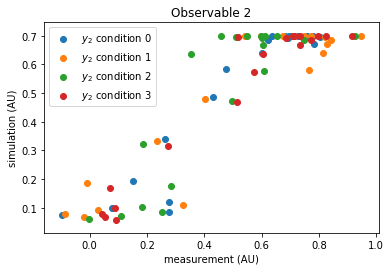

[0.27802839 0.2442628  0.20047829 0.13720158 0.14077162 0.34866577
 0.13598189 0.17920623 0.20485733 0.15558651 0.14919098 0.33880899
 0.48632569 0.71046899 0.91776209 1.00787713 1.28405214 1.17449804
 0.95193897 0.98350151] [0.19131092 0.19134999 0.19143083 0.19159808 0.19194409 0.19265978
 0.19413959 0.197197   0.20350385 0.21647049 0.24294273 0.29617395
 0.39963963 0.58525477 0.85805454 1.1010929  1.15474689 1.11875967
 1.07869223 1.03856099]
[ 0.19015107  0.21010075  0.18889452  0.0658286   0.27598123  0.15798509
  0.12185337 -0.08295271  0.30818869  0.23721661  0.2349646   0.40760183
  0.54890347  0.48942753  0.72387819  0.8638735   1.18849743  1.1740759
  0.91333689  0.89780587] [0.19131092 0.19134999 0.19143083 0.19159808 0.19194408 0.19265976
 0.19413951 0.19719665 0.20350235 0.21646411 0.24291582 0.29606233
 0.39919363 0.58361711 0.85310147 1.09095774 1.14190812 1.10428193
 1.06146781 1.01992692]
[0.32410629 0.27501911 0.34301668 0.28912099 0.08903736 0.26893223
 0.34179311 0.

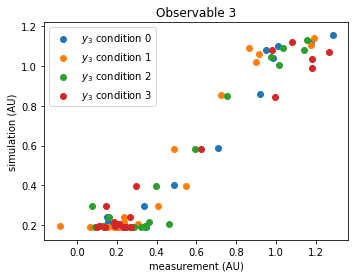

[3.3800185  3.40034792 3.40150952 3.37622779 3.38037098 3.37540823
 3.3828729  3.48298825 3.3212023  3.39852775 3.27874848 3.46015362
 3.29871746 3.51738048 3.54915459 3.71992379 3.85560714 3.57202695
 3.79298007 3.56748708] [3.40516447 3.40517731 3.40520388 3.40525884 3.40537254 3.40560766
 3.40609354 3.40709634 3.40916037 3.4133848  3.42193103 3.43881181
 3.47056519 3.52472404 3.60128695 3.67759484 3.70900409 3.67847806
 3.61705167 3.55621039]
[4.38998397 4.41927764 4.30560142 4.42552052 4.42896173 4.48860866
 4.52224161 4.48363079 4.3486529  4.57380791 4.4556163  4.31048213
 4.54105408 4.55877601 4.61619857 4.69090045 4.7716002  4.71100213
 4.50606696 4.49173669] [4.39824508 4.39825792 4.39828449 4.39833945 4.39845314 4.39868825
 4.3991741  4.40017677 4.40224019 4.40646207 4.4149976  4.43183433
 4.46341353 4.51693719 4.59151433 4.66317347 4.68807893 4.65225052
 4.58675464 4.5245057 ]
[3.22245133 3.51067689 3.51732536 3.30236883 3.45802124 3.46031147
 3.58616031 3.43313594 3.53772997

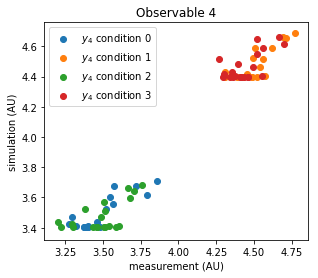

[ 0.13970171  0.50644592  0.3202079   0.14052583  0.15212017 -0.2493509
 -0.02008638  0.1293201   0.29912141  0.00284632  0.35813639  0.21970587
  0.32614425  0.30188574  0.87908836  0.49288721  0.43664726  0.42697984
  0.56226575  0.44919928] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.1007243
 0.10149796 0.1030964  0.10639368 0.11317276 0.12701269 0.15484246
 0.20893527 0.30597656 0.44859878 0.57566147 0.60371226 0.58489782
 0.56395019 0.54296921]
[ 0.21170598  0.33664109  0.17421755 -0.008877    0.11108252  0.15715859
  0.12399861  0.19435185  0.02304884 -0.41092615  0.41174002  0.23352228
  0.2390642   0.386018    0.40709445  0.52679778  0.77816749  0.69641856
  0.36549298  1.00674743] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.10072429
 0.10149791 0.10309622 0.1063929  0.11316942 0.12699862 0.1547841
 0.20870209 0.30512038 0.44600927 0.57036271 0.59700004 0.57732872
 0.55494511 0.53322715]
[ 0.211185   -0.18851965  0.04752748  0.38306261  0.19080738  0

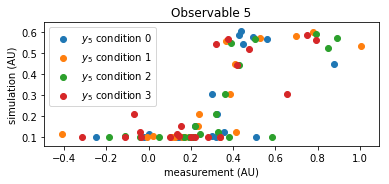

In [22]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

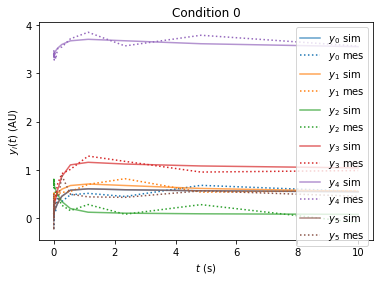

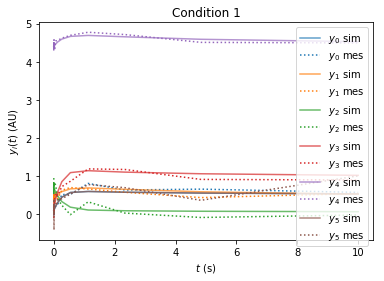

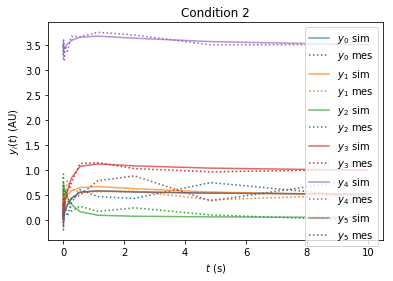

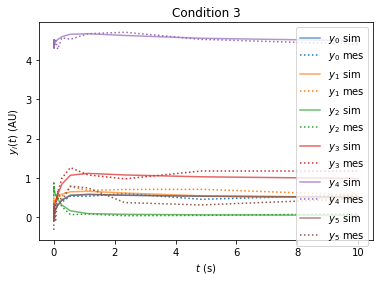

In [23]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), alpha=0.7, c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)

## Hierarchical optimization

In [24]:
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 1
!../../../misc/optimizationOptions.py example_data.h5 -s numStarts 1
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/max_iter 100
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/acceptable_obj_change_tol 1e-5
!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/acceptable_tol 1e-5
!../../../misc/optimizationOptions.py example_data.h5 -s retryOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                hierarchicalOptimization            1
                               numStarts            1
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
   ipopt/watchdog_shortened_iter_trigger            0
                          ipopt/max_iter          100
         ipopt/acc

In [25]:
# gradient check 
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deletemegc/ example_data.h5


HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-12 13:10:51] [INF] [-1/]     0 g:      950.039  fd_c:      950.037  Δ/fd_c: 2.511318e-06  f:      48982.7
[2018-08-12 13:10:51] [WRN] [-1/]     1 g:      -7.3194  fd_c:     -7.32543  Δ/fd_c: -8.240526e-04  f:      48982.7
[2018-08-12 13:10:51] [WRN] [-1/]     2 g:     -33.1087  fd_c:     -33.1122  Δ/fd_c: -1.044981e-04  f:      48982.7
[2018-08-12 13:10:51] [INF] [-1/]     3 g:      3291.56  fd_c:      3291.56  Δ/fd_c: 7.041228e-07  f:      48982.7
[2018-08-12 13:10:51] [INF] [-1/]     4 g:       220132  fd_c:       220132  Δ/fd_c: 1.285397e-08  f:      48982.7
[2018-08-12 13:10:51] [INF] [-1/] Walltime on master: 0.274837s, CPU time of all processes: 0.464620s


In [26]:
# optimization
!PARPE_NO_DEBUG=1 mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemehierarchical/ example_data.h5


HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-12 13:10:51] [INF] [0/dweindl] Running with 4 MPI processes.
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-08-12 13:10:51] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol = 1e-05                 yes
      

array([[-359.91194639, -360.40724625, -362.27664179, -362.31929954,
        -362.99036526, -363.09982898, -363.73408331, -363.93421602,
        -364.01379697, -364.02133523, -364.03355703, -364.03548611,
        -364.035506  , -364.0355329 , -364.03554839, -364.03554848,
        -364.03554848, -364.03554851, -364.03554851]])

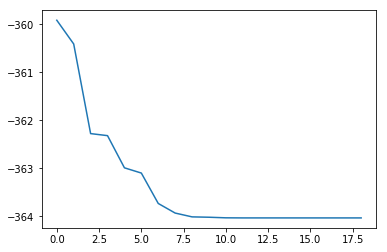

In [27]:
filename = 'deletemehierarchical/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])    
trajectory

In [28]:
compareResults('deletemehierarchical/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 1.064556 0.064556 0.064556
1: 0.500000 0.729757 0.229757 0.459515
2: 0.400000 0.451280 0.051280 0.128200
3: 2.000000 2.000256 0.000256 0.000128
4: 0.100000 0.199861 0.099861 0.998615
5: 2.000000 1.912744 -0.087256 -0.043628
6: 3.000000 3.005152 0.005152 0.001717
7: 0.200000 0.197264 -0.002736 -0.013678
8: 4.000000 3.998233 -0.001767 -0.000442
Status: 4
Cost: -364.035549 (expected: -359.687521)


In [29]:
list(model.getParameterNames())

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'scaling_x1',
 'offset_x2',
 'observable_x1withsigma_sigma']

In [30]:
!rm simh.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deletemehierarchical/_rank00000.h5 / simh.h5 / --at-optimum

Running for start 0


In [31]:
with h5py.File('simh.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


[ 0.21222497 -0.03768793  0.0059771  -0.21634909  0.06662415  0.07117902
  0.35256016 -0.05005438  0.02565056  0.1229272   0.19076048  0.12937107
  0.13573045  0.47313094  0.34031846  0.48084385  0.50975427  0.4453424
  0.67626608  0.55017465] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.1007243
 0.10149796 0.1030964  0.10639368 0.11317275 0.12701267 0.15484242
 0.2089352  0.30597646 0.44859867 0.57566137 0.60371218 0.58489774
 0.56395013 0.54296914]
[ 0.01078388 -0.04013924  0.07650345  0.04320529  0.05184431  0.01899812
  0.08131954  0.10710955  0.03679566 -0.04132656  0.14765435  0.13885827
  0.21222352  0.25818363  0.51688934  0.52088993  0.80831505  0.63562407
  0.65827427  0.57285387] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.10072429
 0.10149791 0.10309622 0.10639289 0.11316941 0.1269986  0.15478407
 0.20870203 0.30512028 0.44600915 0.57036262 0.59699996 0.57732865
 0.55494504 0.53322708]
[ 0.04882468  0.19965676 -0.0190921   0.15880277  0.0665912   

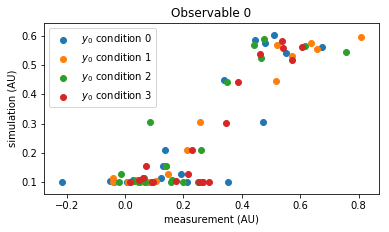

[0.24692785 0.45673752 0.41080699 0.44279896 0.54269522 0.5472063
 0.45422085 0.50442097 0.3679899  0.36420263 0.39503536 0.37443086
 0.44222864 0.50008826 0.53091069 0.54893563 0.69643748 0.81386897
 0.53418117 0.56816564] [0.40001201 0.40002485 0.40005142 0.40010638 0.40022008 0.40045519
 0.40094108 0.40194388 0.4040079  0.40823232 0.41677854 0.4336593
 0.46541263 0.51957141 0.59613425 0.67244219 0.70385161 0.67332568
 0.61189935 0.5510581 ]
[0.46943513 0.59024881 0.30380227 0.37300195 0.32747276 0.38175043
 0.41795182 0.50270297 0.37967032 0.52535214 0.34584468 0.28369024
 0.58125965 0.41117981 0.62973431 0.70019681 0.66071359 0.57583087
 0.43617843 0.54255725] [0.40001201 0.40002485 0.40005142 0.40010638 0.40022008 0.40045518
 0.40094103 0.40194369 0.40400711 0.40822899 0.41676451 0.43360121
 0.46518037 0.51870395 0.59328103 0.66494023 0.68984585 0.65401755
 0.58852173 0.52627281]
[0.39792144 0.45838312 0.53344083 0.50597192 0.40993534 0.42287748
 0.43758464 0.33336713 0.40844684 0

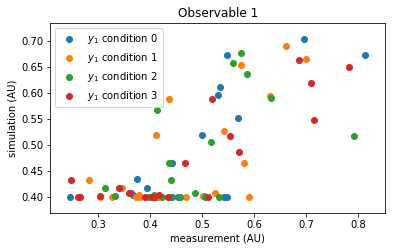

[ 0.69485574  0.72627388  0.77908642  0.63809311  0.68303241  0.75966319
  0.70661843  0.80309469  0.69183801  0.62222988  0.78175945  0.60073625
  0.47474187  0.43191077  0.26346558  0.15106956  0.2778331   0.0765422
  0.27569146 -0.09704166] [0.69997929 0.69995715 0.69991134 0.69981657 0.69962051 0.69921503
 0.69837688 0.69664621 0.69308045 0.68576732 0.67091013 0.64131584
 0.58474473 0.48556592 0.34057668 0.19418785 0.11833594 0.09829803
 0.08521113 0.07320927]
[ 0.94745576  0.59793025  0.54670806  0.77436429  0.67603564  0.54399339
  0.74790909  0.8216325   0.74576214  0.84144661  0.82683416  0.81624084
  0.76619003  0.40103618  0.23596159 -0.01055022  0.32458153  0.03032914
 -0.08466848 -0.02097045] [0.69997859 0.6999557  0.69990835 0.69981037 0.69960769 0.69918852
 0.69832208 0.6965331  0.69284764 0.68529082 0.66994609 0.63941148
 0.58116265 0.4794614  0.33196329 0.18519587 0.11092013 0.09133541
 0.07810671 0.0664479 ]
[ 0.71086693  0.61069088  0.92707075  0.59962152  0.45835732 

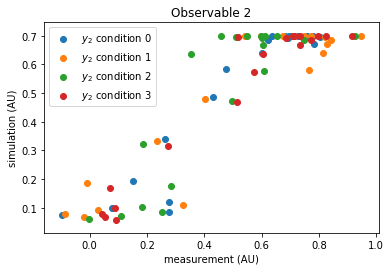

[0.27802839 0.2442628  0.20047829 0.13720158 0.14077162 0.34866577
 0.13598189 0.17920623 0.20485733 0.15558651 0.14919098 0.33880899
 0.48632569 0.71046899 0.91776209 1.00787713 1.28405214 1.17449804
 0.95193897 0.98350151] [0.19131095 0.19135002 0.19143085 0.1915981  0.19194411 0.1926598
 0.19413961 0.19719702 0.20350387 0.2164705  0.24294273 0.29617392
 0.39963957 0.58525466 0.85805442 1.10109285 1.15474688 1.11875967
 1.07869224 1.03856098]
[ 0.19015107  0.21010075  0.18889452  0.0658286   0.27598123  0.15798509
  0.12185337 -0.08295271  0.30818869  0.23721661  0.2349646   0.40760183
  0.54890347  0.48942753  0.72387819  0.8638735   1.18849743  1.1740759
  0.91333689  0.89780587] [0.19131095 0.19135002 0.19143085 0.1915981  0.19194411 0.19265978
 0.19413953 0.19719667 0.20350237 0.21646412 0.24291582 0.29606231
 0.39919357 0.58361699 0.85310135 1.09095769 1.14190811 1.10428193
 1.06146782 1.01992692]
[0.32410629 0.27501911 0.34301668 0.28912099 0.08903736 0.26893223
 0.34179311 0.1

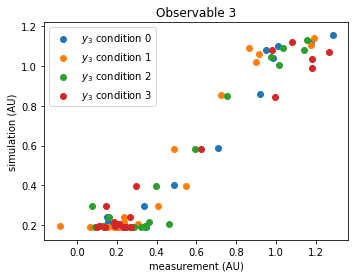

[3.3800185  3.40034792 3.40150952 3.37622779 3.38037098 3.37540823
 3.3828729  3.48298825 3.3212023  3.39852775 3.27874848 3.46015362
 3.29871746 3.51738048 3.54915459 3.71992379 3.85560714 3.57202695
 3.79298007 3.56748708] [3.40516441 3.40517725 3.40520382 3.40525878 3.40537248 3.40560759
 3.40609348 3.40709628 3.4091603  3.41338472 3.42193094 3.4388117
 3.47056503 3.52472381 3.60128665 3.67759459 3.70900401 3.67847808
 3.61705175 3.5562105 ]
[4.38998397 4.41927764 4.30560142 4.42552052 4.42896173 4.48860866
 4.52224161 4.48363079 4.3486529  4.57380791 4.4556163  4.31048213
 4.54105408 4.55877601 4.61619857 4.69090045 4.7716002  4.71100213
 4.50606696 4.49173669] [4.39824532 4.39825816 4.39828473 4.39833969 4.39845339 4.39868849
 4.39917434 4.400177   4.40224042 4.4064623  4.41499781 4.43183451
 4.46341368 4.51693726 4.59151434 4.66317354 4.68807915 4.65225086
 4.58675504 4.52450611]
[3.22245133 3.51067689 3.51732536 3.30236883 3.45802124 3.46031147
 3.58616031 3.43313594 3.53772997 

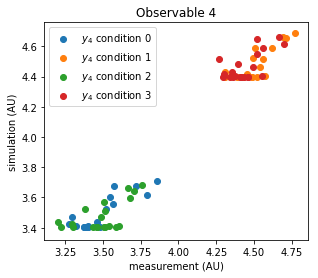

[ 0.13970171  0.50644592  0.3202079   0.14052583  0.15212017 -0.2493509
 -0.02008638  0.1293201   0.29912141  0.00284632  0.35813639  0.21970587
  0.32614425  0.30188574  0.87908836  0.49288721  0.43664726  0.42697984
  0.56226575  0.44919928] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.1007243
 0.10149796 0.1030964  0.10639368 0.11317275 0.12701267 0.15484242
 0.2089352  0.30597646 0.44859867 0.57566137 0.60371218 0.58489774
 0.56395013 0.54296914]
[ 0.21170598  0.33664109  0.17421755 -0.008877    0.11108252  0.15715859
  0.12399861  0.19435185  0.02304884 -0.41092615  0.41174002  0.23352228
  0.2390642   0.386018    0.40709445  0.52679778  0.77816749  0.69641856
  0.36549298  1.00674743] [0.10001911 0.10003953 0.10008179 0.10016923 0.10035013 0.10072429
 0.10149791 0.10309622 0.10639289 0.11316941 0.1269986  0.15478407
 0.20870203 0.30512028 0.44600915 0.57036262 0.59699996 0.57732865
 0.55494504 0.53322708]
[ 0.211185   -0.18851965  0.04752748  0.38306261  0.19080738  

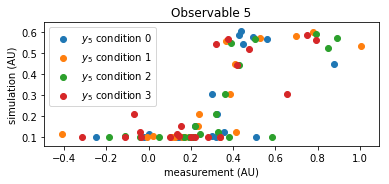

In [32]:
plotCorrelation(ymes, ysim)

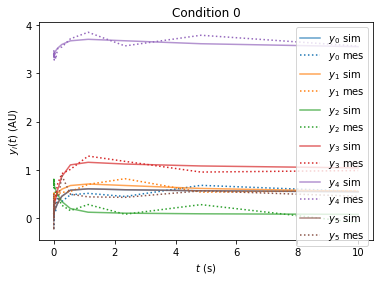

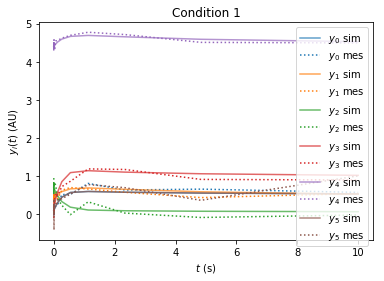

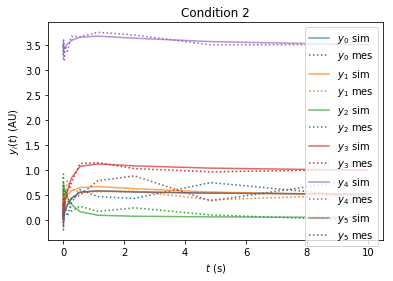

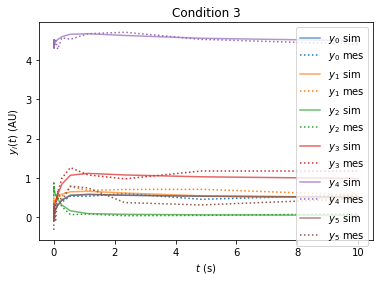

In [33]:
plotTrajectoryFit(ymes, ysim, timepoints)

## Ceres

In [34]:
!cp example_data.h5 example_data_ceres.h5
!../../../misc/optimizationOptions.py example_data_ceres.h5 -s optimizer 1
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deletemeceres/ example_data_ceres.h5


[2018-08-12 13:10:59] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-08-12 13:10:59] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-08-12 13:10:59] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-08-12 13:10:59] [DBG] [1/dweindl] Seeding RNG with 1534072259
[2018-08-12 13:10:59] [DBG] [0/dweindl] Seeding RNG with 1534072259
[2018-08-12 13:10:59] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-08-12 13:10:59] [DBG] [3/dweindl] Seeding RNG with 1534072259
[2018-08-12 13:10:59] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-08-12 13:10:59] [DBG] [2/dweindl] Seeding RNG with 1534072259
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportio

[2018-08-12 13:10:59] [DBG] [1/dweindl] Result for 0.0.0.1 (26): -16177 (0) (0.0015s)
[2018-08-12 13:10:59] [DBG] [1/dweindl] Result for 0.0.0.2 (26): -9130.92 (0) (0.0012s)
[2018-08-12 13:10:59] [DBG] [1/dweindl] Result for 0.0.0.3 (26): -15800.4 (0) (0.0012s)
[2018-08-12 13:10:59] [DBG] [1/dweindl] Message received after waiting 0.000934s.
[2018-08-12 13:10:59] [DBG] [3/dweindl] Message received after waiting 0.015037s.
[2018-08-12 13:10:59] [DBG] [2/dweindl] Message received after waiting 0.031044s.
[2018-08-12 13:10:59] [DBG] [1/dweindl] Result for 0.0.0.0 (27): 97.104 (0) (0.0160s)
[2018-08-12 13:10:59] [DBG] [3/dweindl] Result for 0.0.0.2 (29): 75.9316 (0) (0.0180s)
[2018-08-12 13:10:59] [DBG] [1/dweindl] Message received after waiting 0.000350s.
[2018-08-12 13:10:59] [DBG] [2/dweindl] Result for 0.0.0.1 (28): 88.2731 (0) (0.0322s)
[2018-08-12 13:10:59] [DBG] [1/dweindl] Result for 0.0.0.3 (30): 101.236 (0) (0.0189s)
callbacks.cc:105    3: f:-3.625452e+02 d: 2.73e-01 g: 8.69e+00 

[2018-08-12 13:10:59] [DBG] [2/dweindl] Result for 0.0.0.0 (56): -8972.95 (0) (0.0016s)
[2018-08-12 13:10:59] [DBG] [2/dweindl] Result for 0.0.0.1 (56): -16185.7 (0) (0.0038s)
[2018-08-12 13:10:59] [DBG] [2/dweindl] Result for 0.0.0.2 (56): -9136.37 (0) (0.0013s)
[2018-08-12 13:10:59] [DBG] [2/dweindl] Result for 0.0.0.3 (56): -15809.8 (0) (0.0013s)
[2018-08-12 13:10:59] [DBG] [3/dweindl] Message received after waiting 0.030341s.
[2018-08-12 13:10:59] [DBG] [1/dweindl] Message received after waiting 0.040473s.
[2018-08-12 13:10:59] [DBG] [2/dweindl] Message received after waiting 0.000786s.
[2018-08-12 13:11:00] [DBG] [1/dweindl] Result for 0.0.0.1 (58): 87.56 (0) (0.0165s)
[2018-08-12 13:11:00] [DBG] [2/dweindl] Result for 0.0.0.0 (57): 98.0312 (0) (0.0170s)
[2018-08-12 13:11:00] [DBG] [2/dweindl] Message received after waiting 0.000263s.
[2018-08-12 13:11:00] [DBG] [2/dweindl] Result for 0.0.0.3 (60): 101.618 (0) (0.0167s)
[2018-08-12 13:11:00] [DBG] [3/dweindl] Result for 0.0.0.2 (5

[2018-08-12 13:11:00] [DBG] [2/dweindl] Result for 0.0.0.0 (86): -8973.22 (0) (0.0011s)
[2018-08-12 13:11:00] [DBG] [2/dweindl] Result for 0.0.0.1 (86): -16185.9 (0) (0.0011s)
[2018-08-12 13:11:00] [DBG] [2/dweindl] Result for 0.0.0.2 (86): -9136.59 (0) (0.0011s)
[2018-08-12 13:11:00] [DBG] [2/dweindl] Result for 0.0.0.3 (86): -15810 (0) (0.0011s)
[2018-08-12 13:11:00] [DBG] [2/dweindl] Message received after waiting 0.000804s.
[2018-08-12 13:11:00] [DBG] [1/dweindl] Message received after waiting 0.027583s.
[2018-08-12 13:11:00] [DBG] [3/dweindl] Message received after waiting 0.022193s.
[2018-08-12 13:11:00] [DBG] [2/dweindl] Result for 0.0.0.0 (87): 98.0446 (0) (0.0145s)
[2018-08-12 13:11:00] [DBG] [1/dweindl] Result for 0.0.0.1 (88): 87.5651 (0) (0.0164s)
[2018-08-12 13:11:00] [DBG] [2/dweindl] Message received after waiting 0.000261s.
[2018-08-12 13:11:00] [DBG] [3/dweindl] Result for 0.0.0.2 (89): 76.8129 (0) (0.0254s)
[2018-08-12 13:11:00] [DBG] [2/dweindl] Result for 0.0.0.3 (9

In [35]:
compareResults('deletemeceres/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 1.064556 0.064556 0.064556
1: 0.500000 0.729757 0.229757 0.459515
2: 0.400000 0.451280 0.051280 0.128200
3: 2.000000 2.000256 0.000256 0.000128
4: 0.100000 0.199861 0.099861 0.998615
5: 2.000000 1.912744 -0.087256 -0.043628
6: 3.000000 3.005152 0.005152 0.001717
7: 0.200000 0.197264 -0.002736 -0.013678
8: 4.000000 3.998233 -0.001767 -0.000442
Status: 0
Cost: -364.035549 (expected: -359.687521)


# TODO

## preeequilibration
## different optimizers
## improve timing

In [36]:
list(model.getParameterNames())

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'scaling_x1',
 'offset_x2',
 'observable_x1withsigma_sigma']